# <center> Product Recommendation System for Amazon 👨🏻‍💻</center>

# Table of Contents<a id='0.1'></a>
​
* [Introduction](#1)
* [Data Modeling ](#2)
    * [Import Packages](#2.1)
    * [Custom Classes](#2.2)
    * [Data Preprocessing](#2.3)
        * [Data Reading](#2.3.1)
        * [EDA](#2.3.2)
    * [Recommender System](#2.4)
        * [Collaberative Filtering](#2.4.1)
        * [Content based recommedations](#2.4.2)

# 1 <a id='1.'>Introduction</a>

In this project, I'm diving into the world of product recommendations for Amazon's electronics. We all know the struggle of finding the right tech amidst endless options.  This project aims to tackle that by building a recommendation system that personalizes suggestions based on user behavior.

I'll be using a dataset from the Amazon Reviews repository, focusing specifically on electronics.  We'll explore user IDs, product IDs, ratings, and timestamps to understand user preferences and product interactions.  To make these recommendations sing, I'll be implementing collaborative filtering techniques. This approach analyzes patterns in user purchases and ratings to connect users with similar tastes, ultimately suggesting products they might love.

The goal? A recommendation system that can handle the massive data landscape of Amazon's electronics.  By providing users with relevant and personalized suggestions, this system can boost customer satisfaction and potentially increase sales for Amazon.  So, buckle up, as we embark on a journey to create the perfect product recommendation system for electronics enthusiasts.

# 2 <a id='2'> Data Modeling 📚</a>

## 2.1 <a id='2.1'>Import Packages</a>

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline
plt.style.use("ggplot")
import plotly.graph_objects as go

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# 2.2 <a id='2.1'>Custom Classes 🔍</a>

In [13]:
class PipelineRecommendation():
    def __init__(self):
        self.project = 'churn prediction '
        
    def get_percent_missing(self, df):
        percent_missing = df.isnull().sum() * 100 / len(df)
        missing_value_df = pd.DataFrame({'column_name': df.columns,
                                             'percent_missing': percent_missing})
        missing_value_df.sort_values('percent_missing', inplace=True)
        percent_missing = df.isnull().sum() * 100 / len(df)
        
        print('Percentage of Missing Values: ')

        return percent_missing
    
    
    def unique_counts(self, df):
        """
        Returns the number of unique values and unique values for each feature in the given dataframe.

        Parameters:
        df (pandas.DataFrame): The input dataframe.

        Returns:
        unique_counts_df (pandas.DataFrame): A dataframe containing the feature names, the number of unique values, the unique values, and the data type of each feature.
        """
        unique_counts = df.nunique()
        unique_values = [df[column].unique() for column in df.columns]
        data_types = [str(df[column].dtype) for column in df.columns]
        unique_counts_df = pd.DataFrame({'feature': df.columns, 'unique_count': unique_counts, 'unique_values': unique_values, 'data_type': data_types})
        return unique_counts_df
    
    
    def dataframe_insights(self, df):
        """
        This function provides basic insights about a dataframe.

        Parameters:
        df (pandas dataframe): The dataframe to analyze.

        Returns:
        A dictionary containing basic insights about the dataframe.
        """
        insights = {}
        insights['Number of records'] = len(df)
        insights['Number of columns'] = len(df.columns)
        insights['Columns'] = list(df.columns)
        insights['Number of unique values in each column'] = df.nunique().to_dict()
        insights['Missing values'] = df.isnull().sum().sum()
        insights['Percentage of missing values in each column'] = (df.isnull().sum() / len(df) * 100).round(2).to_dict()
        insights['Data types'] = df.dtypes.to_dict()
        insights['Summary statistics'] = df.describe().to_dict()
        insights['Correlation matrix'] = df.corr().to_dict()
        insights['Number of duplicated rows'] = len(df[df.duplicated()])
        insights['Duplicate rows'] = list(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).to_dict('index').values())
        return insights

In [14]:
recommendation = PipelineRecommendation()

# 2.3 <a id='2.3'> Data Preprocessing</a>

In [15]:
amazon_ratings = pd.read_csv('../input/amazon-ratings/ratings_Beauty.csv')
amazon_ratings['user_id'] = pd.factorize(amazon_ratings['UserId'])[0]
# amazon_ratings = amazon_ratings.sort_values(by = 'UserId', ascending = False)
amazon_ratings.head(5)

,UserId,ProductId,Rating,Timestamp,user_id
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,0
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,1
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200,2
3,A1WMRR494NWEWV,0733001998,4.0,1382572800,3
4,A3IAAVS479H7M7,0737104473,1.0,1274227200,4


In [16]:
amazon_ratings.shape

(2023070, 5)

# 2.3.1 <a id='2.3.2'> EDA</a>


In [17]:
recommendation.unique_counts(amazon_ratings)

,feature,unique_count,unique_values,data_type
UserId,UserId,1210271,"[A39HTATAQ9V7YF, A3JM6GV9MNOF9X, A1Z513UWSAAO0...",object
ProductId,ProductId,249274,"[0205616461, 0558925278, 0733001998, 073710447...",object
Rating,Rating,5,"[5.0, 3.0, 4.0, 1.0, 2.0]",float64
Timestamp,Timestamp,4231,"[1369699200, 1355443200, 1404691200, 138257280...",int64
user_id,user_id,1210271,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",int64


In [18]:
recommendation.get_percent_missing(amazon_ratings)

Percentage of Missing Values: 


UserId       0.0
ProductId    0.0
Rating       0.0
Timestamp    0.0
user_id      0.0
dtype: float64

In [19]:
recommendation.dataframe_insights(amazon_ratings)

/tmp/ipykernel_34/1649206779.py:53: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



{'Number of records': 2023070,
 'Number of columns': 5,
 'Columns': ['UserId', 'ProductId', 'Rating', 'Timestamp', 'user_id'],
 'Number of unique values in each column': {'UserId': 1210271,
  'ProductId': 249274,
  'Rating': 5,
  'Timestamp': 4231,
  'user_id': 1210271},
 'Missing values': 0,
 'Percentage of missing values in each column': {'UserId': 0.0,
  'ProductId': 0.0,
  'Rating': 0.0,
  'Timestamp': 0.0,
  'user_id': 0.0},
 'Data types': {'UserId': dtype('O'),
  'ProductId': dtype('O'),
  'Rating': dtype('float64'),
  'Timestamp': dtype('int64'),
  'user_id': dtype('int64')},
 'Summary statistics': {'Rating': {'count': 2023070.0,
   'mean': 4.149035871225415,
   'std': 1.31150457371216,
   'min': 1.0,
   '25%': 4.0,
   '50%': 5.0,
   '75%': 5.0,
   'max': 5.0},
  'Timestamp': {'count': 2023070.0,
   'mean': 1360388736.5637374,
   'std': 46118604.216807574,
   'min': 908755200.0,
   '25%': 1350259200.0,
   '50%': 1372809600.0,
   '75%': 1391472000.0,
   'max': 1406073600.0},
  'u

In [20]:
# Calculate the frequency of ratings
rating_counts = amazon_ratings['Rating'].value_counts().sort_index()

# Create the bar chart using Plotly
fig = go.Figure(data=go.Bar(x=rating_counts.index, y=rating_counts.values))

# Customize the chart layout and style
fig.update_layout(
    title='Frequency of Ratings',
    xaxis_title='Rating',
    yaxis_title='Frequency',
    xaxis=dict(type='category'),
    yaxis=dict(type='linear'),
    plot_bgcolor='white',  # Set the background color
    bargap=0.2,  # Set the gap between bars
    bargroupgap=0.1,  # Set the gap between groups of bars
    font=dict(
        family='Arial',  # Set the font family
        size=14,  # Set the font size
        color='black'  # Set the font color
    )
)

# Display the chart
fig.show()

In [21]:
# Calculate average rating for each product
product_ranking = amazon_ratings.groupby(['ProductId'])['Rating'].mean().reset_index().sort_values(by = 'Rating', ascending=False)
product_ranking

,ProductId,Rating
0,0205616461,5.0
135683,B00551HYQC,5.0
135663,B0054ZSIXC,5.0
135667,B00550UX52,5.0
135668,B00550YQP0,5.0
...,...,...
137246,B00586PNN0,1.0
137239,B00585I1VW,1.0
137235,B005854H5G,1.0
137222,B00583Q2MY,1.0


In [ ]:
# Create a distribution chart using Plotly
fig = go.Figure(data=[go.Histogram(x=product_ranking['Rating'], nbinsx=10)])

fig.update_layout(
    title="Average Rating Distribution",
    xaxis_title="Rating",
    yaxis_title="Count",
    bargap=0.1,
    bargroupgap=0.1
)

fig.update_traces(marker_color='rgba(50, 171, 96, 0.6)')

fig.show()

In [23]:
products_ratings = amazon_ratings.pivot_table(index='ProductId', columns='Rating', values='Timestamp', aggfunc='count', fill_value=0)
products_ratings.columns = ['Rating ' + str(col) for col in products_ratings.columns]
products_ratings['Frequency'] = products_ratings.sum(axis=1)
# products_ratings = products_ratings.sort_values('Frequency', ascending=False)

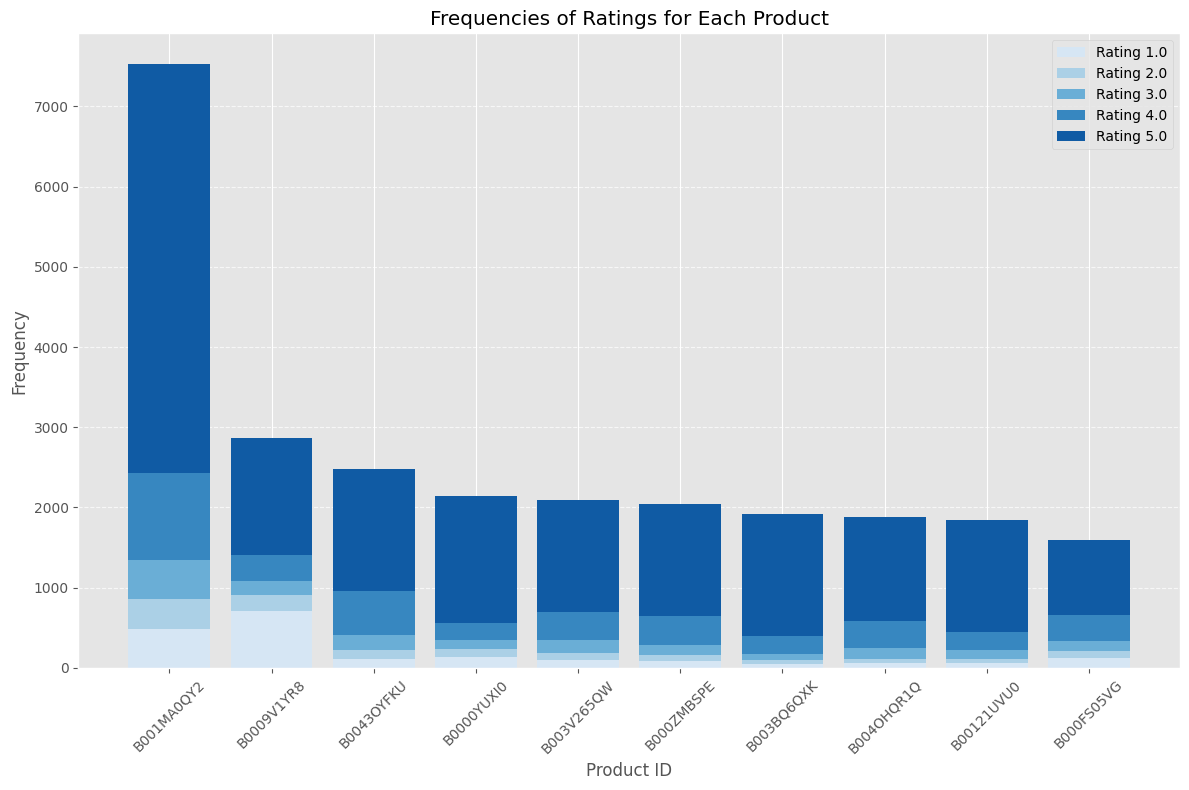

In [24]:
# Extract data from the dataframe
df = products_ratings.sort_values('Frequency', ascending=False).head(10)

ratings = df[['Rating 1.0', 'Rating 2.0', 'Rating 3.0', 'Rating 4.0', 'Rating 5.0']].values
product_ids = df.index.values

# Define a blue color palette
colors = sns.color_palette('Blues', n_colors=5)

# Plot the bar chart with a white background
plt.figure(figsize=(12, 8), facecolor='w')
for i in range(5):
    plt.bar(product_ids, ratings[:, i], bottom=ratings[:, :i].sum(axis=1), color=colors[i], label='Rating ' + str(i+1) + '.0')

# Customize the plot
plt.xlabel('Product ID')
plt.ylabel('Frequency')
plt.title('Frequencies of Ratings for Each Product')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
len(amazon_ratings['UserId'].unique())

1210271

In [26]:
len(amazon_ratings['user_id'].unique())

1210271

In [27]:
# Pivot the table to get ratings as columns and count frequency
users_ratings = amazon_ratings.pivot_table(index='user_id', columns='Rating', aggfunc='size', fill_value=0)

# Add the 'Frequency' column
users_ratings['Frequency'] = users_ratings.sum(axis=1)

# Rename the columns
users_ratings.columns = ['Rating ' + str(col) for col in users_ratings.columns]

# Reset the index to make 'UserId' a regular column
users_ratings = users_ratings.reset_index()

users_ratings = users_ratings.sort_values(by = 'Rating Frequency', ascending = False)

# Set the 'UserId' column as the index
users_ratings.set_index('user_id', inplace=True)

users_ratings.head(10)

,Rating 1.0,Rating 2.0,Rating 3.0,Rating 4.0,Rating 5.0,Rating Frequency
user_id,,,,,,
847,27,49,60,129,124,389
3905,0,0,16,38,282,336
2287,1,6,22,125,172,326
10293,4,13,20,67,174,278
107881,0,9,14,69,184,276
8351,183,6,6,3,77,275
4229,10,9,6,23,221,269
1822,7,24,46,75,107,259
45464,16,27,52,41,113,249


<Figure size 1600x800 with 0 Axes>

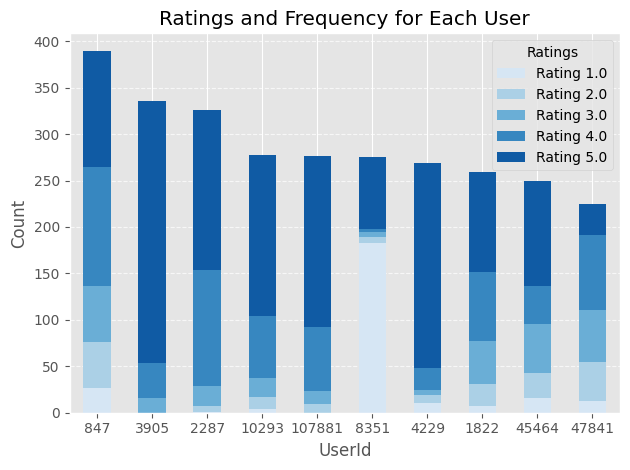

In [28]:
# Use a blue color palette
colors = sns.color_palette('Blues', n_colors=5)

# Plot the bar chart with a wider figure
plt.figure(figsize=(16, 8))
users_ratings[['Rating 1.0', 'Rating 2.0', 'Rating 3.0', 'Rating 4.0', 'Rating 5.0']].head(10).plot(kind='bar', stacked=True, color=colors)

# Customize the plot
plt.xlabel('UserId')
plt.ylabel('Count')
plt.title('Ratings and Frequency for Each User')
plt.xticks(rotation=0)
plt.legend(title='Ratings', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# 2.4 <a id='2.4'> Recommender System</a>

## 2.4.1 <a id='2.4.1'> Collaberative Filtering</a>

In [29]:
def recommend_products(user_id, user_similarity, user_item_matrix):
    # Get the products that the user has not rated yet.
    unrated_products = user_item_matrix.loc[user_id, :].isna()
    unrated_products = unrated_products.index.values

    # Get the top-k similar users.
    k = 5
    similar_users = user_similarity[user_id].argsort()[-k:][::-1]

    # Get the ratings of the unrated products by the similar users.
    similar_user_ratings = user_item_matrix.loc[similar_users, unrated_products]

    # Calculate the weighted average of the ratings.
    recommended_ratings = similar_user_ratings.mean(axis=0)

    # Sort the recommended ratings by descending order.
    recommended_ratings = np.array(recommended_ratings).argsort()[::-1]

    # Return the top-k recommended products.
    return unrated_products[recommended_ratings[:k]]

In [30]:
amazon_ratings1 = amazon_ratings.head(30000)
amazon_ratings1 = amazon_ratings1.sort_values(by = 'user_id', ascending = True)
amazon_ratings1.head(4)

,UserId,ProductId,Rating,Timestamp,user_id
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,0
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,1
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200,2
3,A1WMRR494NWEWV,0733001998,4.0,1382572800,3


In [31]:
len(amazon_ratings1['ProductId'].unique())

1858

In [32]:
%%time
user_item_matrix = amazon_ratings1.pivot_table(index='user_id', columns='ProductId', values='Rating', fill_value=0)
user_item_matrix

CPU times: user 2.72 s, sys: 1.45 s, total: 4.16 s
Wall time: 3.98 s


ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B00007KH0O,B00007KQF3,B00007KUSE,B00007L1HG,B00007L1HT,B00007L1IE,B00007L64J,B00007LB75,B00007LVDA,B00007M0CP
user_id,,,,,,,,,,,,,,,,,,,,,
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
28454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
28455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [33]:
%%time
user_similarity = cosine_similarity(user_item_matrix)

CPU times: user 1min 33s, sys: 6.28 s, total: 1min 39s
Wall time: 28.9 s


In [36]:
# Calculate item-item similarity matrix (cosine similarity)
item_sim_matrix = np.dot(user_item_matrix.T, user_item_matrix)

In [37]:
pd.DataFrame(item_sim_matrix)

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,50,0,0,0,0
1854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,41,0,0,0
1855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,69,0,0
1856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0


In [38]:
pd.DataFrame(user_similarity)

,0,1,2,3,4,5,6,7,8,9,...,28448,28449,28450,28451,28452,28453,28454,28455,28456,28457
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
28454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
28455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
28456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [39]:
# Pivot the table to get ratings as columns and count frequency
users_ratings = amazon_ratings1.pivot_table(index='user_id', columns='Rating', aggfunc='size', fill_value=0)

# Add the 'Frequency' column
users_ratings['Frequency'] = users_ratings.sum(axis=1)

# Rename the columns
users_ratings.columns = ['Rating ' + str(col) for col in users_ratings.columns]

# Reset the index to make 'UserId' a regular column
users_ratings = users_ratings.reset_index()

users_ratings = users_ratings.sort_values(by = 'Rating Frequency', ascending = False)

# Set the 'UserId' column as the index
users_ratings.set_index('user_id', inplace=True)

users_ratings.head(10)

,Rating 1.0,Rating 2.0,Rating 3.0,Rating 4.0,Rating 5.0,Rating Frequency
user_id,,,,,,
3905,0,0,0,2,29,31
2287,0,0,3,6,8,17
11063,2,0,1,1,13,17
5296,0,0,3,6,5,14
6,0,0,0,0,13,13
4229,2,0,0,0,7,9
32,9,0,0,0,0,9
4547,1,0,0,1,7,9
7,0,0,0,0,9,9


In [40]:
amazon_ratings1['user_id'].value_counts().idxmax()

3905

In [41]:
# Get the user ID of the user you want to recommend products to.
user_id = amazon_ratings1['user_id'].value_counts().idxmax()

# Recommend products to the user.
recommended_products = recommend_products(int(user_id), user_similarity, user_item_matrix)

# Print the recommended products.
print(recommended_products)

['B0000535UN' 'B0000535UM' 'B00006IGL4' 'B00006IGL5' 'B0000535U2']


In [42]:
# Make recommendations for a given user
user_id = amazon_ratings1['user_id'].value_counts().idxmax()
top_n = 3

# Retrieve the items not rated by the user
user_items = amazon_ratings1.loc[amazon_ratings1['user_id'] == user_id, 'ProductId'].tolist()
all_items = amazon_ratings1['ProductId'].unique()
items_to_rate = list(set(all_items) - set(user_items))

# Predict ratings for the items not rated by the user
item_predictions = np.dot(user_item_matrix.loc[user_id], item_sim_matrix) / np.sum(item_sim_matrix, axis=1)

# Get top N item recommendations based on predicted ratings
top_item_indices = np.argsort(item_predictions)[::-1][:top_n]
top_item_recommendations = [all_items[i] for i in top_item_indices]

print(f"Top {top_n} Recommendations for User {user_id}: {top_item_recommendations}")

Top 3 Recommendations for User 3905: ['B0000532QT', 'B000067O42', 'B000052ZEH']


# 2.4.2 <a id='2.4.2'> Content based recommedations</a>

In [43]:
def recommend_products(user_id, user_item_matrix):
    # Get the products that the user has not rated yet.
    unrated_products_index = pd.Index(pd.isna(user_item_matrix[user_id]))

    # Predict the ratings for the unrated products.
    predicted_ratings = user_item_matrix.dot(svd.inverse_transform(user_item_matrix[user_id]))

    # Sort the predicted ratings by descending order.
    predicted_ratings = np.array(predicted_ratings).argsort()[::-1]

    # Return the top-k recommended products.
    return user_item_matrix.columns[unrated_products_index][predicted_ratings[:5]]

In [44]:
# Function to generate recommendations for a user
def generate_recommendations(user_id, top_n):
    user_ratings = user_item_matrix.loc[user_id]
    user_predictions = item_sim_matrix.dot(user_ratings)
    recommended_indices = user_predictions.argsort()[-top_n:][::-1]
    recommended_products = user_item_matrix.columns[recommended_indices]
    return recommended_products

In [45]:
svd = TruncatedSVD(n_components=100)

# Fit the TruncatedSVD object to the user-item matrix.
user_item_matrix_svd = svd.fit_transform(user_item_matrix)

In [46]:
pd.DataFrame(user_item_matrix_svd)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-8.374199e-17,4.742361e-16,8.995250e-17,-5.598960e-16,7.037208e-16,3.441723e-15,2.796515e-15,1.526151e-15,-9.440527e-16,4.883546e-16,...,-8.092336e-11,-4.946769e-12,-1.773717e-10,-4.124863e-11,2.831475e-11,1.613792e-10,8.406448e-12,-2.043942e-10,-6.209605e-12,1.022840e-11
1,-3.831109e-16,-2.168031e-16,4.931894e-16,1.060420e-15,-2.731654e-15,1.041616e-15,-6.076645e-15,-5.109993e-15,-1.156042e-14,2.945986e-15,...,2.469997e-10,-3.054017e-10,1.241808e-10,5.173874e-10,-6.680120e-11,-8.121095e-10,-4.660500e-10,4.894147e-11,-3.131553e-10,6.478366e-10
2,-6.385182e-16,-3.613385e-16,8.219824e-16,1.767367e-15,-4.552756e-15,1.736026e-15,-1.012774e-14,-8.516655e-15,-1.926736e-14,4.909976e-15,...,4.116661e-10,-5.090028e-10,2.069680e-10,8.623123e-10,-1.113353e-10,-1.353516e-09,-7.767500e-10,8.156912e-11,-5.219256e-10,1.079728e-09
3,-1.331480e-16,1.292405e-16,8.986777e-17,-4.379113e-17,-5.560303e-16,2.991319e-17,-1.584994e-16,-2.382621e-16,5.097627e-16,-3.442147e-16,...,-1.867868e-12,9.201103e-12,5.862296e-12,-2.405321e-12,6.596074e-13,8.946498e-12,9.623084e-12,7.488601e-12,5.647198e-12,-9.816995e-12
4,8.179544e-18,6.037615e-17,-1.240572e-17,-1.222816e-17,-1.478321e-17,2.035105e-17,-1.703647e-16,-2.781610e-16,-1.460351e-17,2.704451e-17,...,3.317214e-18,1.020567e-18,9.834853e-19,4.235136e-19,-1.641496e-18,1.142317e-19,-1.154603e-18,1.155101e-18,-7.353429e-19,1.167496e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28453,3.672303e-03,4.950782e-07,2.644953e-04,-6.057117e-05,3.891068e-05,9.432529e-05,-9.451384e-06,8.679771e-05,8.193274e-06,2.930534e-04,...,2.670929e-03,-2.847533e-04,-6.622642e-03,-1.337920e-02,-5.536187e-03,1.169820e-02,-7.858311e-03,-4.423495e-03,3.848765e-03,-1.101774e-03
28454,3.672303e-03,4.950782e-07,2.644953e-04,-6.057117e-05,3.891068e-05,9.432529e-05,-9.451384e-06,8.679771e-05,8.193274e-06,2.930534e-04,...,2.670929e-03,-2.847533e-04,-6.622642e-03,-1.337920e-02,-5.536187e-03,1.169820e-02,-7.858311e-03,-4.423495e-03,3.848765e-03,-1.101774e-03
28455,1.836152e-03,2.475391e-07,1.322476e-04,-3.028559e-05,1.945534e-05,4.716264e-05,-4.725692e-06,4.339886e-05,4.096637e-06,1.465267e-04,...,1.335464e-03,-1.423766e-04,-3.311321e-03,-6.689600e-03,-2.768094e-03,5.849098e-03,-3.929155e-03,-2.211748e-03,1.924382e-03,-5.508868e-04
28456,1.836152e-03,2.475391e-07,1.322476e-04,-3.028559e-05,1.945534e-05,4.716264e-05,-4.725692e-06,4.339886e-05,4.096637e-06,1.465267e-04,...,1.335464e-03,-1.423766e-04,-3.311321e-03,-6.689600e-03,-2.768094e-03,5.849098e-03,-3.929155e-03,-2.211748e-03,1.924382e-03,-5.508868e-04


In [47]:
# Get the user ID of the user you want to recommend products to.
user_id = amazon_ratings1['user_id'].value_counts().idxmax()

# Recommend products to the user.
recommended_products = user_item_matrix_svd[user_id].argsort()[::-1][:5]

# Print the recommended products.
print(recommended_products)

[72 41 71 45 68]


In [48]:
amazon_ratings1.head(3)

,UserId,ProductId,Rating,Timestamp,user_id
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,0
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,1
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200,2


In [49]:
user_id = amazon_ratings1['user_id'].value_counts().idxmax()
top_n = 3

recommendations = generate_recommendations(user_id, top_n)
print(f"Top {top_n} Recommendations for User {user_id}: {recommendations}")

Top 3 Recommendations for User 3905: Index(['B0000535RA', 'B0000535UT', 'B0000535UM'], dtype='object', name='ProductId')


In [50]:
pd.DataFrame(item_sim_matrix)

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,50,0,0,0,0
1854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,41,0,0,0
1855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,69,0,0
1856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0


In [51]:
pd.DataFrame(cosine_similarity(user_item_matrix.T))

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
pd.DataFrame(user_similarity)

,0,1,2,3,4,5,6,7,8,9,...,28448,28449,28450,28451,28452,28453,28454,28455,28456,28457
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
28454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
28455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
28456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [53]:
# Calculate item-item similarity matrix
items_sim_matrix = cosine_similarity(user_item_matrix.T)
pd.DataFrame(items_sim_matrix)

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
X = user_item_matrix.T
X1 = X
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
print(decomposed_matrix.shape)
pd.DataFrame(decomposed_matrix)

(1858, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.119891e-15,-2.820865e-14,2.636876e-14,-7.345749e-14,2.323044e-14,-1.436447e-13,-6.234224e-14,1.051601e-13,-3.928054e-14,4.871919e-14
1,9.658473e-15,-2.465499e-14,3.539860e-15,-4.432291e-14,-1.627993e-13,2.601617e-13,8.535144e-14,7.555719e-14,-1.735846e-13,1.994954e-13
2,-3.533492e-16,-3.828917e-16,-2.440925e-16,1.137564e-15,-1.196019e-15,-5.732870e-15,-2.618525e-15,4.926164e-15,5.967203e-15,4.658009e-15
3,-1.958184e-16,6.087200e-17,-2.183522e-16,2.609171e-16,-6.165831e-16,3.115286e-15,-2.575779e-15,6.218108e-16,1.915313e-16,1.456229e-15
4,3.590457e-16,9.048684e-15,-2.152057e-14,7.272488e-14,-4.229354e-14,1.291115e-13,3.123135e-14,-1.874110e-13,6.527117e-14,-1.070446e-13
...,...,...,...,...,...,...,...,...,...,...
1853,1.752906e-13,-6.255736e-13,7.648984e-13,-3.071676e-12,5.780087e-13,-4.937404e-12,-4.394668e-12,3.969414e-12,-4.492355e-12,2.540010e-12
1854,3.760395e-14,-1.901632e-13,2.068722e-13,-7.257086e-13,-5.486055e-13,3.798659e-13,-2.204681e-13,-6.813624e-13,-2.387090e-12,-1.130390e-12
1855,4.592130e-13,9.513762e-13,-1.868910e-12,4.624556e-12,-1.697554e-11,1.560345e-11,-6.288024e-13,-7.382669e-12,-1.640485e-11,-3.964190e-11
1856,1.563739e-15,5.076377e-15,-1.019595e-14,4.121976e-14,-5.446079e-15,-2.217871e-14,6.382583e-14,1.631381e-14,1.810066e-14,-6.970951e-14


In [55]:
correlation_matrix = np.corrcoef(decomposed_matrix)
print(correlation_matrix.shape)
pd.DataFrame(correlation_matrix)

(1858, 1858)


,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,1.000000,-0.165860,0.635134,-0.183498,-0.956961,0.669302,-0.069069,0.858258,0.671764,0.902579,...,0.061704,0.873278,-0.853569,0.575618,-0.891023,0.927917,-0.190916,-0.615733,-0.270180,-0.077041
1,-0.165860,1.000000,-0.314024,0.511763,-0.052745,0.047363,0.076128,0.141913,0.047145,-0.077357,...,-0.518749,-0.300099,-0.151455,-0.430880,-0.009153,0.052488,0.462888,0.121786,-0.400098,-0.003831
2,0.635134,-0.314024,1.000000,-0.005981,-0.558269,0.009060,-0.514928,0.503148,0.011843,0.733332,...,0.025406,0.688820,-0.212293,0.731961,-0.726629,0.447458,-0.810540,-0.686289,-0.123345,0.087643
3,-0.183498,0.511763,-0.005981,1.000000,0.102261,-0.350099,-0.632138,0.131019,-0.347721,-0.181278,...,-0.745847,-0.313132,0.065365,0.155183,-0.110039,0.045099,0.039507,0.048765,-0.663648,-0.637257
4,-0.956961,-0.052745,-0.558269,0.102261,1.000000,-0.725306,0.038708,-0.922842,-0.727787,-0.889874,...,0.005392,-0.860515,0.889673,-0.440195,0.911734,-0.930377,0.109906,0.585056,0.281752,0.066400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,0.927917,0.052488,0.447458,0.045099,-0.930377,0.767779,-0.007965,0.894597,0.770245,0.793752,...,-0.084320,0.697984,-0.933574,0.474830,-0.856793,1.000000,0.064097,-0.502552,-0.461472,-0.260306
1854,-0.190916,0.462888,-0.810540,0.039507,0.109906,0.441516,0.671484,-0.159456,0.439316,-0.420311,...,0.053023,-0.366465,-0.222729,-0.684150,0.393521,0.064097,1.000000,0.623071,-0.029495,-0.070235
1855,-0.615733,0.121786,-0.686289,0.048765,0.585056,-0.104231,0.424531,-0.728907,-0.106824,-0.869516,...,0.369376,-0.447977,0.503789,-0.820973,0.809926,-0.502552,0.623071,1.000000,0.507146,0.167011
1856,-0.270180,-0.400098,-0.123345,-0.663648,0.281752,0.009476,0.474311,-0.560200,0.006902,-0.364332,...,0.873250,0.126474,0.469669,-0.521650,0.501427,-0.461472,-0.029495,0.507146,1.000000,0.674791


In [56]:
# Function to generate recommendations for a user
def generate_recommendations(user_id, top_n):
    user_ratings = user_item_matrix.loc[user_id]
    user_predictions = np.dot(item_sim_matrix, user_ratings)
    user_predictions = np.where(user_ratings > 0, -1, user_predictions)  # Set already rated items to -1
    recommended_indices = np.argsort(user_predictions)[-top_n:][::-1]
    recommended_products = user_item_matrix.columns[recommended_indices]
    return recommended_products

In [57]:
users_ratings.head(10)

,Rating 1.0,Rating 2.0,Rating 3.0,Rating 4.0,Rating 5.0,Rating Frequency
user_id,,,,,,
3905,0,0,0,2,29,31
2287,0,0,3,6,8,17
11063,2,0,1,1,13,17
5296,0,0,3,6,5,14
6,0,0,0,0,13,13
4229,2,0,0,0,7,9
32,9,0,0,0,0,9
4547,1,0,0,1,7,9
7,0,0,0,0,9,9


In [58]:
amazon_ratings1['UserId'].value_counts().idxmax()

'A281NPSIMI1C2R'

In [59]:
amazon_ratings1[amazon_ratings1['UserId'] == amazon_ratings1['UserId'].value_counts().idxmax()].sort_values(by = 'ProductId', ascending = False)

,UserId,ProductId,Rating,Timestamp,user_id
26825,A281NPSIMI1C2R,B00006IGL8,5.0,1121817600,3905
26793,A281NPSIMI1C2R,B00006IGL5,5.0,1128211200,3905
26783,A281NPSIMI1C2R,B00006IGL4,5.0,1121817600,3905
26771,A281NPSIMI1C2R,B00006IGL3,5.0,1130630400,3905
26755,A281NPSIMI1C2R,B00006IGL2,5.0,1169337600,3905
26431,A281NPSIMI1C2R,B00006FE30,5.0,1085356800,3905
26219,A281NPSIMI1C2R,B00006AG74,4.0,1052611200,3905
26206,A281NPSIMI1C2R,B000069J49,5.0,1053561600,3905
23527,A281NPSIMI1C2R,B00005V9TI,5.0,1067817600,3905
23521,A281NPSIMI1C2R,B00005V61K,5.0,1143331200,3905


In [60]:
i = "B00006IGL8"

product_names = list(X.index)
product_ID = product_names.index(i)
print(product_ID)

correlation_product_ID = correlation_matrix[product_ID]
print(correlation_product_ID.shape)

Recommend = list(X.index[correlation_product_ID > 0.95])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:9]

1736
(1858,)


['B000050B6X',
 'B000050FET',
 'B0000532XP',
 'B0000532ZI',
 'B00005331J',
 'B000053321',
 'B0000535V2',
 'B0000537S1',
 'B0000537S2']

In [61]:
# Example usage
user_id = amazon_ratings1['user_id'].value_counts().idxmax()
top_n = 2

recommendations = generate_recommendations(user_id, top_n)
print(f"Recommendations for User {user_id}: {recommendations}")

Recommendations for User 3905: Index(['B000052YOL', 'B000055Z3C'], dtype='object', name='ProductId')


## “When you are asked if you can do a job, tell ’em, ‘Certainly I can!’ Then get busy and find out how to do it.” — Theodore Roosevelt.